# Automated image caption generation using Transfer Learning and LSTM 

## Overview

Image captioning is the task of providing a natural language description to an image. The architecture behind such an application involves a Convolutional Neural Network to encode the input image in the form of numerical vectors and a decoder network to generate a descriptive text sequence based on the objects identified in the image. Inspired by Neural Machine Translation, sophisticated models using attention-based Recurrent Neural Networks have shown path-breaking results in caption generation.

In this project, I'm implementing an image captioning model by experimenting with pre-trained ConvNets and an attention-based LSTM RNN. 



*   Dataset used: Flickr8k
*   Framework: PyTorch
*   Key Libraries: Pandas, Numpy, torchvision
*   Pre-trained Model: RESNET152



## Implementation

Importing the essential libraries

In [ ]:
# Importing the essential libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import pandas as pd
from string import punctuation
import os
from os import listdir
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import zipfile as Z
from PIL import Image
import glob
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import random
from torchvision.transforms import ToPILImage
#from spellchecker import SpellChecker 
import string
import re
import pandas.testing as tm



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
torch.cuda.is_available()

True

In [ ]:
from torchtext import data, datasets
TEXT = data.Field()

tokenizer = data.get_tokenizer('toktok') # toktok tokenizer function

**Downloading data files from personal G-drive folder**

In [ ]:
from google.colab import drive
drive.mount("./drive")

In [ ]:
# Importing and extracting files from G-Drive
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/capstone/Flickr8k_Dataset.zip", 'r')
zip_ref.extractall('/content/sample_data/Flickr8k')
zip_ref.close()


zip_ref = zipfile.ZipFile("/content/drive/My Drive/capstone/Flickr8k_text.zip", 'r')
zip_ref.extractall('/content/sample_data/Flickr8k')
zip_ref.close()

In [ ]:
# Key file paths
root = "/content/sample_data/Flickr8k/"
image_dir = root + 'Flicker8k_Dataset/'
caption_file = 'Flickr8k.token.txt'


# Initial Analysis of the Dataset

First of all how many images do we have in total?


In [ ]:
images = os.listdir(image_dir)
n_images = len(images)
print('Total number of images available in the Flickr8k dataset: ', n_images)

Total number of images available in the Flickr8k dataset:  8091



## Q1: How does the captions file look like?

In [ ]:
# A look into captions file
captions = pd.read_csv(root + caption_file, sep='\t', header=None, names = ['image_id', 'caption'])
captions.head()

image_id                                            caption
0  1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg#1              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg#2   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg#3  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg#4  A little girl in a pink dress going into a woo...

Dissecting the image_id column into two with '#' as the separator.

In [ ]:
captions[['image', 'caption_id']] = captions['image_id'].str.split('#',expand = True)
captions.head()

image_id  ... caption_id
0  1000268201_693b08cb0e.jpg#0  ...          0
1  1000268201_693b08cb0e.jpg#1  ...          1
2  1000268201_693b08cb0e.jpg#2  ...          2
3  1000268201_693b08cb0e.jpg#3  ...          3
4  1000268201_693b08cb0e.jpg#4  ...          4

[5 rows x 4 columns]

## Q2: How many observations are available in the 'captions' dataframe?

In [ ]:
# Number of records
captions.shape
print('Number of records in captions dataframe: ', captions.shape[0])


Number of records in captions dataframe:  40460


## Q3: How many captions per image? Some statistics on the captions.

In [ ]:
# Number of images per caption ID
c = Counter([values for values in captions['caption_id']])
print(c)

Counter({'0': 8092, '1': 8092, '2': 8092, '3': 8092, '4': 8092})


**Observation** 

There are five captions per image. 


Let's check some sample images.

The dimension of the image is 500 x 354


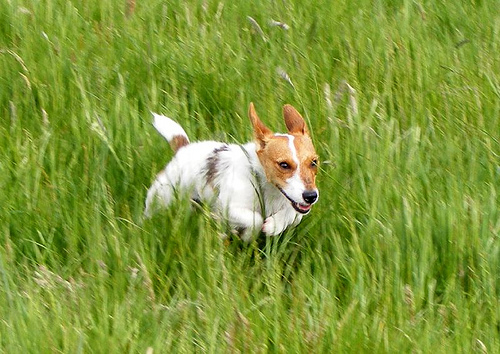

In [ ]:
# Sample image - first image in the folder

# path = "/content/sample_data/Flickr8k/Flicker8k_Dataset/" 
imagesList = listdir(image_dir)
img = Image.open(image_dir + imagesList[0] )
width, height = img.size
print("The dimension of the image is", width, "x", height)
img

The dimension of the image is 479 x 500


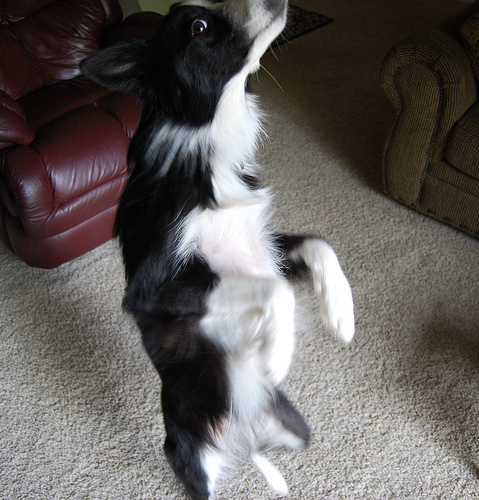

In [ ]:
# Randomly pick a file from the folder to view
random_filename = random.choice([
    x for x in os.listdir(image_dir)
    if os.path.isfile(os.path.join(image_dir, x))
])
img = Image.open(image_dir + random_filename)
width, height = img.size
print("The dimension of the image is", width, "x", height)
img

Randomly selecting 5 images to display along with their respective captions.

In [ ]:
# Randomly sample 5 images 
samples = random.sample(imagesList, 5)
samples

['3412036192_d8cd12ed3f.jpg',
 '2548777800_d7b9cf1c2b.jpg',
 '2502935765_a0ae1fa7be.jpg',
 '2176980976_7054c99621.jpg',
 '525968880_82623392d1.jpg']

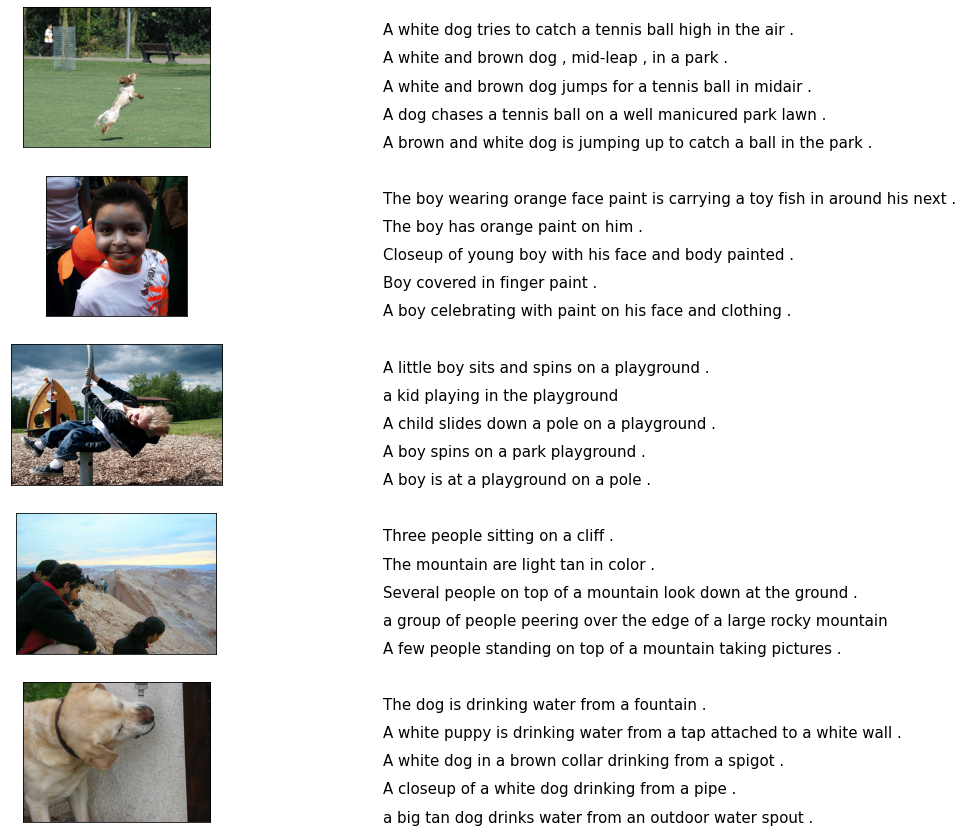

In [ ]:
# Visualize randomly sampled images alongside their captions
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

count = 1
fig = plt.figure(figsize = (15,15))

# Read the image from file
for img in samples:
  img_path = image_dir + img
  
  # Open the image from 'images' folder
  pil_image = Image.open(img_path)
  
  # Convert PIL image to torch tensor
  rgb_img = pil2tensor(pil_image)
  
  # Fetch the captions for the sample images from captions dataframe
  target = list(captions["caption"].loc[captions["image"] == img].values)
 

  # Create a subplot grid 
  ax = fig.add_subplot(len(samples), 2, count, xticks=[], yticks=[] )
  ax.imshow(rgb_img.numpy().transpose(1, 2, 0))

  # increment sub-plot index
  count += 1
   
  ax = fig.add_subplot(len(samples),2,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(target))
  # Place captions by the side of the image
  for i, val in enumerate(target):
    ax.text(0,i,val,fontsize=15)

  # increment sub-plot index
  count += 1

**Examining the captions data more**

### Distribution of the length of captions

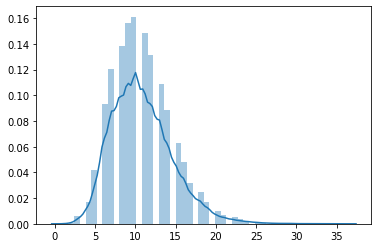

In [ ]:
# Distribution of captions
custom_punct = punctuation.replace("'", "")
cap_len = []
for c in captions.caption:
  n_words = len(c.translate(str.maketrans('','', custom_punct)).split())    #output_str = re.sub('[^A-Za-z0-9]+', ' ', input_str)
  cap_len.append(n_words)

sns.distplot(cap_len);
captions['n_words'] = cap_len

In [ ]:
# Maximum and minimum length of captions
max_length = max(cap_len)
min_length = min(cap_len)

print('Maximum number of words in the captions: ', max_length)
print('Minimum number of words in the captions: ', min_length)


Maximum number of words in the captions:  36
Minimum number of words in the captions:  1


We see from the distribution that we have the minimum number of words in the captions is 1. Let's check how many such captions are there and what are the respective images.

In [ ]:
captions[captions['n_words'] == 1]

image_id caption  ... caption_id n_words
9310   2428275562_4bde2bc5ea.jpg#0       A  ...          0       1
33365  3640443200_b8066f37f6.jpg#0       a  ...          0       1

[2 rows x 5 columns]

In [ ]:
# Corresponding index values
indx = [val for val in captions[captions['n_words'] == 1].index.astype(int)]
print(indx)

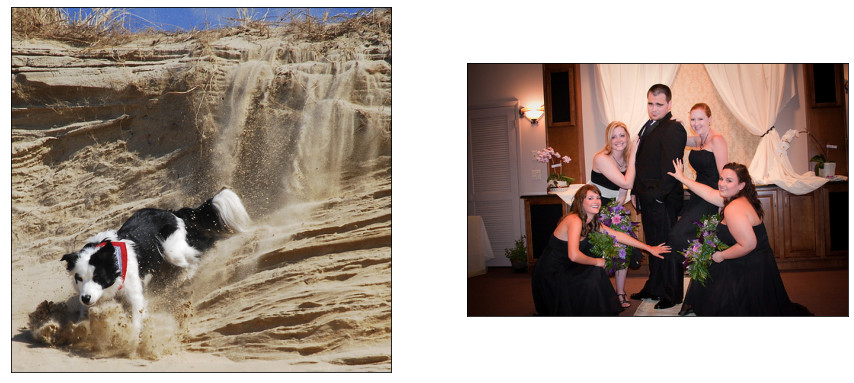

In [ ]:
# Checking the corresponding images
img_id = []
for i in captions[captions['n_words'] == 1]['image']:
  img_id.append(i)

fig, axes = plt.subplots(1, 2, figsize = (15,15), squeeze=False )
axes = axes.ravel()

for i in range(2):
  axes[i].set_xticks([]); axes[i].set_yticks([])
  if i == 0:
    img = Image.open(image_dir + img_id[0])
    rgb_image = pil2tensor(img)
    axes[i].imshow(rgb_image.numpy().transpose(1, 2, 0))
    
  else:
    img = Image.open(image_dir + img_id[1])
    rgb_image = pil2tensor(img)
    axes[i].imshow(rgb_image.numpy().transpose(1, 2, 0))



It appears that we have a couple of captions that have inadequate information pertaining to the image they correspond to. We will eliminate them from our model building due to their low degree of usefulness.

Let's also investigate if there are issues in the image_ids.

**Examining the image IDs in the captions file for errors**

In [ ]:
# If any filename doesn't have a proper .jpg extension, we mark it as Invalid filename
def invalid_filename_check(captions):
  for filenames in captions["image"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        return(filenames)
        break

fname = invalid_filename_check(captions)
print("Error file: {}".format(fname))

Error file: 2258277193_586949ec62.jpg.1


In [ ]:
# Verify if the invalid image ID in the captions dataframe has an actual image file 

if fname in os.listdir(image_dir):
  print('True')
elif fname[:-2] in os.listdir(image_dir):
  print('File exists in the name ', fname[:-2])
else:
  print('False')


False


### Data cleaning: Removal of invalid rows from 'captions' dataframe

In [ ]:
# Now add the indices of this invalid image_id to the previous created 'indx' list
for i in captions[captions['image'] == fname].index:
  indx.append(i)

print(indx)

[9310, 33365, 6730, 6731, 6732, 6733, 6734]


In [ ]:
# Removing the records correspodning to the indices
captions = captions.drop(index=indx, axis = 1)

# Reset the index after completing drop
captions = captions.reset_index(drop = True)

# Verify the shape of the captions file now - Should be 40453 rows 
print(captions.shape)


(40453, 5)


In [ ]:
# Number of unique images in the dataset
print('Number of unique images in the dataset: ', captions['image'].nunique())

n_captions_per_img = captions.groupby(['image'], as_index=False)['caption_id'].count().iloc[:,1].unique()

print('Number of captions per image:', n_captions_per_img)

Number of unique images in the dataset:  8091
Number of captions per image: [5 4]


**Observations**

1) Captions file has two columns: image_id and caption

2) Total number of observations in the captions dataset is 40,460

3) Number of unique images available = 8091

4) Average number of captions per image: 5

5) Average length of captions (in number of words) = 10. Maximum length of the captions = 36 (words)

6) Images are of varying dimensions. So, we have to essentially apply a transformation technique to reshape the image according to the model we choose to apply.

7) After cleaning the data, the final number of observations are **40453 with 8091 unique valid images**.




# Caption pre-processing

Clean captions and create the base vocabulary for the decoder part to work on.


We also bind start and end tokens to mark the beginning and end of captions.



**Step 1:** 

We start with creating a dictionary with 'keys' as image_id and values as respective 'captions'.

In the sample above, we observe instances where there are single characters such as "**\<apostrophe>s**". These characters affect our main vocabulary as they don't carry meaningful information during caption generation. In the next step, we perform text cleaning which involves,



1.   Punctuation removal
2.   Removing single characters such as 's', 'a', etc.
3.   Removing numbers
4.   Spell-check


The final step here would be to create a list or counter of all the unique meaningful words in our captions vocaulary.



In [ ]:
# To remove punctuations
def remove_punctuation(raw_caption):
    clean_text = re.sub(r'[^\w\s]','',raw_caption)
    return(clean_text)


# To remove single characters such as 'a'
def remove_single_character(raw_caption):
    clean_text = re.sub(r"\b[a-zA-Z]\b", "", raw_caption)
    return(clean_text)

# To remove numeric values
def remove_numeric(raw_caption):
  clean_text = re.sub(r'\d+', '', raw_caption)
  return(clean_text)


def text_cleaning(raw_caption):
  ''' the main function for text preprocessing and cleaning 
      Called functions:
          - remove_punctuation()
          - remove_single_character()
          - remove_numeric()
      Standard argument: caption
      '''

  # Convert text to lower case. Strip trailing spaces
  raw_caption = raw_caption.lower().strip()

  # Remove punctuations
  clean_cap = remove_punctuation(raw_caption)

  # Remove single characters
  clean_cap = remove_single_character(clean_cap)

  # Remove numeric characters from captions
  clean_cap = remove_numeric(clean_cap)
  
  return clean_cap


In [ ]:
# Perform text cleaning 
for ix, cap in enumerate(captions.caption.values):
  clean_cap = text_cleaning(cap)
  captions['caption'].iloc[ix] = clean_cap


In [ ]:
# Not executed. What is the need for this dictionary??
# Create a dictionary with image_id as key and respective clean captions as values
descriptions = dict()

for row in (captions.loc[:, ['image', 'caption']]).itertuples():
  if row[1]  in descriptions:
    descriptions[row[1]].append(row[2])
  else:
    descriptions[row[1]] = list()
    descriptions[row[1]].append(row[2])
print('Number of keys in the dictionary: ', len(descriptions))

Number of keys in the dictionary:  8091


In [ ]:
# Not executed. what is the need for this dictionary?
# Getting the first key-value pair for verification
next(iter(descriptions.items()))

('1000268201_693b08cb0e.jpg',
 [' child in  pink dress is climbing up  set of stairs in an entry way ',
  ' girl going into  wooden building ',
  ' little girl climbing into  wooden playhouse ',
  ' little girl climbing the stairs to her playhouse ',
  ' little girl in  pink dress going into  wooden cabin '])

In [ ]:
# Assign start and end tokens to captions for processing
def bind_captions(captions):
  start = '<start> '
  end = ' <end>'
  # Add start and end tokens to the captions
  for ix, row in enumerate(captions['caption']):
    
    captions['caption'][ix] = start + row + end
  return

# Bind all captions with start and end tokens
bind_captions(captions)


In [ ]:
# Retain only image_id and caption column going forward
captions_df = captions[['image', 'caption']]
print('Shape of the duplicate captions datafrme: ', captions_df.shape)
captions_df.head()


Shape of the duplicate captions datafrme:  (40453, 2)


image                                            caption
0  1000268201_693b08cb0e.jpg  <start>  child in  pink dress is climbing up  ...
1  1000268201_693b08cb0e.jpg   <start>  girl going into  wooden building  <end>
2  1000268201_693b08cb0e.jpg  <start>  little girl climbing into  wooden pla...
3  1000268201_693b08cb0e.jpg  <start>  little girl climbing the stairs to he...
4  1000268201_693b08cb0e.jpg  <start>  little girl in  pink dress going into...

In [ ]:
# Build a vocabulary with the cleaned captions
def vocabulary(captions):
  vocab = []
  for caption in captions['caption'].values:
    vocab.extend(caption.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

vocabulary = vocabulary(captions_df)

import pickle
# Create a pickle file for storing the vocabulary file
with open(root + 'vocab.pkl', 'wb') as f:
  pickle.dump(vocabulary, f)

Vocabulary Size : 8770


This **'vocabulary'** is a list of all the unique words in the captions (including the **\<start>** and **\<end>** tokens).

In [ ]:
# Word count in the vocabulary
c = Counter(vocabulary)

''' The code below iterates over the Counter and stores words with frequency > 3 in a separate list '''
words = []
for i in range(len(c)):
  if list(c.values())[i] > 3:
    words.append(list(c.keys())[i])

In [ ]:
# Number of words in the list now
len(words)

3424

To account for unknown words and padding, we'll have to add two tokens **\<pad>** and **\<unk>** to the vocabulary.


**Note**: Padding is required because we need all the sentences to be of the same length before processing them through LSTM.

In [ ]:
# Now adding '<pad>' and '<unk>' to the list of words
append_list = ['<pad>', '<unk>']

words = append_list + words

#words.extend(append_list)
len(words)

3426

In [ ]:
words[:10]

['<pad>',
 '<unk>',
 '<start>',
 'child',
 'in',
 'pink',
 'dress',
 'is',
 'climbing',
 'up']

Now that we have done some preliminary investigation on the training dataset, we are going to lay out the overall model architecture.

<figure>
<center>
<img src='https://docs.google.com/uc?export=download&id=1tr7T-urBqLG26bBC_yTldEK_7-WaKfDh' />
<figcaption>End to end Encoder-Decoder architecture for Image captioning</figcaption></center>
</figure>

Here for the encoder architecture, we are using RESNET152 pre-trained image recognition model and eliminating the last two layers to retain just until the vector representation of our input image(s).


The Decoder architecture is going to be an LSTM RNN with soft attention.

In a sequence model, we will need to convert words in the caption to numbers. So, we here we define a helper class for mapping unique words in the vocabulary to a number.

In [ ]:
# Build the word to index and index to word mapping
class mapping(object):
    """Simple vocabulary mapping wrapper which maps every unique word to an integer ID and vice versa. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """ Adding word to the vocabulary """
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
# Create an instance of the mapping and adding all the words
map = mapping()

for i in words:
  map.add_word(i)

len(map)

3426

So what is the purpose of this mapping? Let me illustrate this with an example below.

We convert a piece of text (appended with <start> and <end> tokens just like our captions) into a set of numbers.

In [ ]:
# Consider a piece of text
text = '<start> the girl is playing with the barbie doll <end>'

[map(tokens) for tokens in text.split()]


[2, 23, 16, 7, 34, 35, 23, 1, 1493, 15]

Now our index2word and word2index mappings are done. We have altogether 3895 words in our mapping (which include \<start>, \<end>, \<pad> and \<unk>)

Now let's get the images ready.

In [ ]:
# Function for fetching images from the folder

def fetch_images(path, ds):
  '''Function to pull up the train, test and validation images from the image folder
        Parameters:
            path : the image folder
            ds : the category of images to be pulled (train, test, validation)'''
  img_set = []

  for i in os.listdir(path):
    if i in ds:
      img_set.append(i)

  return(img_set)

In [ ]:

# training set
train_fname = root + 'Flickr_8k.trainImages.txt'
train_ds = list(open(train_fname, 'r').read().strip().split('\n'))
train_imgs = fetch_images(image_dir, train_ds)
print('Number of training data: ', len(train_imgs))

# validation set
valid_fname =  root + 'Flickr_8k.devImages.txt'
valid_ds = list(open(valid_fname, 'r').read().strip().split('\n'))
valid_imgs = fetch_images(image_dir, valid_ds)
print('Number of validation data: ', len(valid_imgs))

# test set
test_fname =  root + 'Flickr_8k.testImages.txt'
test_ds = list(open(test_fname, 'r').read().strip().split('\n'))
test_imgs = fetch_images(image_dir, test_ds)
print('Number of test data: ', len(test_imgs))


Number of training data:  6000
Number of validation data:  1000
Number of test data:  1000


In [ ]:
valid_imgs[0]

captions_df[captions_df['image'] == '2090339522_d30d2436f9.jpg']

image                                            caption
21918  2090339522_d30d2436f9.jpg  <start>  man in  green hat be someplace up hig...
21919  2090339522_d30d2436f9.jpg  <start>  man in  green hat be take  self portr...
21920  2090339522_d30d2436f9.jpg    <start>  man in  hat at  scenic overlook  <end>
21921  2090339522_d30d2436f9.jpg  <start>  man wear  green canvas hat with  dist...
21922  2090339522_d30d2436f9.jpg  <start> man with green hate and sunglasses on ...

In [ ]:
test_imgs[0]

captions_df[captions_df['image'] == '2436081047_bca044c1d3.jpg']

Let's define the transforms for the images.

Transformations applied:
1.  Resize images into 224x224
2.  Random crop with padding of 4 and padding_mode as 'reflect'
3.  Random Horizontal flip
4.  Convert to tensor
5.  Normalize images according to the pre-defined standard that is set for applying RESNET.

These transformations are a good way of augmenting the training data.


In [ ]:
# Defining the transforms
# stats obtained from PyTorch official tutorial for transfer learning

stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# Crop size matches the input dimensions expected by the pre-trained ResNet
preprocess_image = transforms.Compose([ 
    transforms.Resize(256),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'), 
    transforms.RandomHorizontalFlip(p = 0.6),
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace=True)]) # Using ResNet standards


valid_txms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats, inplace=True)])


A quick experiment about how this transformation would take effect. 

We randomly pick an image, apply the transform and denormalize the transformed image to see how it appears after data augmentation.


The dimension of the image is 333 x 500


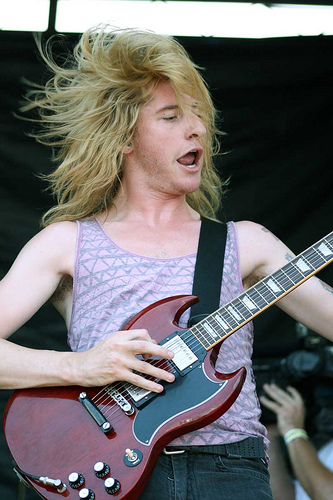

In [ ]:
# Randomly picked image
random_filename = random.choice([
    x for x in os.listdir(image_dir)
    if os.path.isfile(os.path.join(image_dir, x))
])
img = Image.open(image_dir + random_filename)
width, height = img.size
print("The dimension of the image is", width, "x", height)
img

In [ ]:
# Check the transformation on the random image
input_image = Image.open(image_dir + random_filename)
input_tensor = preprocess_image(input_image)

Size of the image : (224, 224, 3)


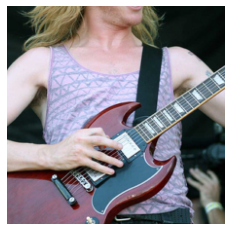

In [ ]:
def denormalize(image):
  #  Denormalize image to view the augmentation 
    image = image.numpy().transpose(1, 2, 0) 
    mean = stats[0]
    stdd = stats[1]
    image = (image * stdd + mean).clip(0,1)
    plt.axis('off')
    plt.imshow(image)
    print('Size of the image :', image.shape)
    return 

    
denormalize(input_tensor)

In [ ]:
# Create the Flickr8k class
class FlickrDataset(torch.utils.data.Dataset):
  def __init__(self, df, vocab, image_dir, transform = None):
    self.df = df
    self.image_dir = image_dir
    self.vocab = vocab
    self.transform = transform

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
            idx = idx.tolist()
    
    img_id = self.df['image'][idx]
    # print(img_id)
    caption = self.df['caption'][idx]
    # print(caption)

    img_path = os.path.join(self.image_dir, img_id)
    image = Image.open(open(img_path, 'rb'))

    # Apply transformation to the image
    if self.transform is not None:
      image = self.transform(image)

    # Convert caption to indexes from the vocab file - eg. shown below this code chunk
    tokens = tokenizer(caption)     # toktok tokenizer; Whitespacetokenizer(NLTK) or plain caption.split() will also work
    # print(tokens)
    caption = []
    caption.extend([self.vocab(token) for token in tokens])
    caption = torch.Tensor(caption)
    return image, caption
  
  def __len__(self):
    return len(self.df)


Here's a small example of how tokenization can work in torchtext, NLTK and plain split().

In [ ]:
test_string = '<start>  child in  pink dress is climbing up  set of stairs in an entry way  <end>'
print('original string: \n' + test_string + '\n')

# Using torchtext
from torchtext import data, datasets
TEXT = data.Field()
tokenizer = data.get_tokenizer(tokenizer = 'toktok') # toktok tokenizer function
print('tokenized string using torchtext: \n',tokenizer(test_string))
print('\n')

# NLTK WhitespaceTokenizer
from nltk.tokenize import WhitespaceTokenizer
ws_tok = WhitespaceTokenizer()
print('tokenized string using whitespacetokenizer: \n', ws_tok.tokenize(test_string))
print('\n')


# Pandas text.split() tokenization
print('Default split() tokenization result: \n', test_string.split())


original string: 
<start>  child in  pink dress is climbing up  set of stairs in an entry way  <end>

tokenized string using torchtext: 
 ['<start>', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<end>']


tokenized string using whitespacetokenizer: 
 ['<start>', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<end>']


Default split() tokenization result: 
 ['<start>', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<end>']


In [ ]:
# Train-test split
train_size = round(0.95*len(captions_df)) + 3 
test_size = len(captions_df) - train_size
train_size

38433

In [ ]:
valid_df = captions_df[train_size:].reset_index(drop = True)
valid_df.head()

image                                            caption
0  537559285_29be110134.jpg  <start>  brown and white sheltie leaping over ...
1  537559285_29be110134.jpg  <start>  collie is running through an obstacle...
2  537559285_29be110134.jpg  <start> collie jumping over  training hurdle t...
3  537559285_29be110134.jpg  <start> collie making  jump over  yellow hurdl...
4  537559285_29be110134.jpg     <start> the dog is leaping over  hurdle  <end>

**Note**: The reason for adding 3 to train_size is to not have the same image in both train and test sets. Since we removed some invalid records earlier, one or more images do not have exactly 5 captions assigned. To make sure that we maintain homegenity between train and test sets, we experiment with values and assign the split sizes accordingly. 

Now, let's experiment with a small sample of data and understand what's happening here under the hood.

In [ ]:
sample = FlickrDataset(df = captions_df[0:1],
                         vocab = map, image_dir= image_dir, transform=preprocess_image)

In [ ]:
sample[0]

(tensor([[[-1.8782, -1.8268, -1.8782,  ..., -0.6281, -0.6452, -0.6452],
          [-1.8097, -1.8268, -1.8610,  ..., -0.6794, -0.6452, -0.5253],
          [-1.7925, -1.8097, -1.8268,  ..., -0.5082, -0.4911, -0.4911],
          ...,
          [-1.6727, -1.6042, -1.4329,  ..., -1.2274, -1.2788, -1.3644],
          [-1.3130, -1.2617, -1.3815,  ..., -1.2445, -1.2788, -1.3987],
          [-1.6555, -1.3302, -1.3815,  ..., -1.3130, -1.2959, -1.3130]],
 
         [[-1.4055, -1.3704, -1.3704,  ..., -0.8277, -0.8978, -0.8627],
          [-1.3704, -1.3529, -1.3704,  ..., -0.8803, -0.8803, -0.7402],
          [-1.3354, -1.3704, -1.3354,  ..., -0.7227, -0.7402, -0.6527],
          ...,
          [-1.6856, -1.5980, -1.4930,  ..., -1.5105, -1.5105, -1.5805],
          [-1.2304, -1.2654, -1.4930,  ..., -1.5105, -1.5280, -1.5980],
          [-1.6506, -1.4930, -1.5280,  ..., -1.4755, -1.4930, -1.5805]],
 
         [[-1.4733, -1.4210, -1.3513,  ..., -1.0376, -1.1247, -1.1421],
          [-1.3861, -1.3339,

We see how the image and the caption have got convert into tensors. Now, let's apply it to the train and test sets.

In [ ]:
train_ds = FlickrDataset(df = captions_df[:train_size].reset_index(drop = True),
                         vocab = map, image_dir= image_dir, transform=preprocess_image)

valid_ds = FlickrDataset(df = captions_df[train_size:].reset_index(drop = True),
                         vocab = map, image_dir= image_dir, transform=valid_txms)

In [ ]:
train_ds[1]

(tensor([[[-0.0801, -0.6281,  0.9988,  ..., -1.7412, -1.7583, -1.7754],
          [ 0.0056, -0.9020,  0.0227,  ..., -1.7240, -1.6898, -1.7240],
          [ 0.1083, -1.0562, -0.6623,  ..., -1.8097, -1.8268, -1.7583],
          ...,
          [-0.7993, -0.7479, -0.7308,  ..., -0.4739,  0.0912, -0.0801],
          [ 0.3481, -0.1486, -0.2856,  ...,  0.3481, -1.1760, -1.4500],
          [ 1.3413, -0.1486, -0.6281,  ..., -0.2342, -1.5014, -1.4672]],
 
         [[ 0.4853, -0.7227,  0.8179,  ..., -1.7031, -1.7206, -1.7556],
          [ 0.5728, -0.7577, -0.0049,  ..., -1.6856, -1.6681, -1.7031],
          [ 0.6078, -0.7577, -0.5476,  ..., -1.8081, -1.7031, -1.5105],
          ...,
          [-0.6527, -0.5651, -0.5301,  ..., -0.9153, -1.0378, -0.9328],
          [ 0.2402, -0.0749, -0.2150,  ..., -0.4776, -1.6155, -1.6506],
          [ 0.9930, -0.2150, -0.6001,  ..., -0.9503, -1.4930, -1.4405]],
 
         [[ 0.5311, -0.6018,  0.2522,  ..., -1.6999, -1.7173, -1.6999],
          [ 0.6008, -0.8284,

In [ ]:
valid_ds[1]

(tensor([[[-0.9877, -0.7993, -0.8678,  ...,  0.1254,  0.0398,  0.9132],
          [-1.1589, -0.8507, -0.9192,  ...,  0.2453,  0.3138,  1.0331],
          [-0.8164, -1.1075, -1.0048,  ...,  0.0741,  0.1939,  0.9132],
          ...,
          [-0.5253, -0.6794, -0.8849,  ..., -0.9705, -0.4739, -0.9534],
          [-0.5253, -0.8164, -0.8507,  ..., -1.4500, -1.2445, -0.7137],
          [-0.6109, -0.5596, -0.7137,  ..., -1.1932, -1.3987, -1.0048]],
 
         [[-0.6001, -0.5651, -0.3550,  ...,  0.1001,  0.1001,  0.9405],
          [-0.7927, -0.5301, -0.4251,  ...,  0.1702,  0.3277,  1.0630],
          [-0.4776, -0.7927, -0.5476,  ...,  0.0651,  0.2227,  0.9580],
          ...,
          [-0.3725, -0.6877, -1.0903,  ..., -0.5826, -0.1275, -0.6527],
          [-0.2150, -0.5651, -0.8102,  ..., -0.9678, -0.8102, -0.2675],
          [-0.4601, -0.5126, -0.7402,  ..., -0.7752, -1.0378, -0.6001]],
 
         [[-1.0550, -1.1073, -0.8981,  ...,  0.1651,  0.1302,  0.8448],
          [-1.1421, -1.0027,

Now, the challenge lies in the captions being of varying length. Since we are using batches for processing the images, we would need to pad the captions to the maximum length of the captions in the corresponding batch that they belong to.

Consider a batch of 64 images along with their captions. Suppose the maximum length of the captions in this batch is '28', we would want to pad zeros all of the captions in this batch to this length. The Dataloader class in PyTorch does have an in-built [collate_fn](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn). However, we need to write a custom function for our case to achieve padding sequences. 

In [ ]:
def custom_collate_fn(data):
    # Step 1: Sort the batch based on lengths of captions in descending order
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths


What happens if we stack a dimension to a tensor? Here's an illustration.

In [ ]:
img = tuple(train_ds[0][0])
img


(tensor([[-0.2684, -0.9705, -1.6898,  ..., -0.4568, -0.4226, -0.3541],
         [-1.3644, -1.3302, -1.7412,  ..., -0.4568, -0.3712, -0.3883],
         [-1.1932, -1.6213, -1.6384,  ..., -0.4568, -0.3883, -0.3712],
         ...,
         [-0.5596, -0.5253, -0.5082,  ...,  2.0948,  2.2318,  2.1290],
         [-0.5767, -0.5424, -0.5082,  ...,  1.6153,  2.1119,  2.1804],
         [-0.5596, -0.5767, -0.5082,  ...,  1.6153,  2.0263,  1.8722]]),
 tensor([[-0.3375, -0.9328, -1.6506,  ..., -0.2850, -0.2500, -0.2325],
         [-1.4930, -1.3354, -1.6681,  ..., -0.3200, -0.2150, -0.1975],
         [-1.1954, -1.5630, -1.5105,  ..., -0.3200, -0.2150, -0.1975],
         ...,
         [ 0.1527,  0.0826,  0.1001,  ...,  1.5357,  1.6583,  1.3957],
         [ 0.1176,  0.1001,  0.1001,  ...,  1.0280,  1.5357,  1.5882],
         [ 0.1176,  0.0826,  0.1176,  ...,  1.2906,  1.6057,  1.0105]]),
 tensor([[-0.3578, -1.0724, -1.6127,  ..., -0.3753, -0.3404, -0.4450],
         [-1.4036, -1.3861, -1.5953,  ..., -0

In [ ]:
img = torch.stack(img,0)
img

tensor([[[-0.2684, -0.9705, -1.6898,  ..., -0.4568, -0.4226, -0.3541],
         [-1.3644, -1.3302, -1.7412,  ..., -0.4568, -0.3712, -0.3883],
         [-1.1932, -1.6213, -1.6384,  ..., -0.4568, -0.3883, -0.3712],
         ...,
         [-0.5596, -0.5253, -0.5082,  ...,  2.0948,  2.2318,  2.1290],
         [-0.5767, -0.5424, -0.5082,  ...,  1.6153,  2.1119,  2.1804],
         [-0.5596, -0.5767, -0.5082,  ...,  1.6153,  2.0263,  1.8722]],

        [[-0.3375, -0.9328, -1.6506,  ..., -0.2850, -0.2500, -0.2325],
         [-1.4930, -1.3354, -1.6681,  ..., -0.3200, -0.2150, -0.1975],
         [-1.1954, -1.5630, -1.5105,  ..., -0.3200, -0.2150, -0.1975],
         ...,
         [ 0.1527,  0.0826,  0.1001,  ...,  1.5357,  1.6583,  1.3957],
         [ 0.1176,  0.1001,  0.1001,  ...,  1.0280,  1.5357,  1.5882],
         [ 0.1176,  0.0826,  0.1176,  ...,  1.2906,  1.6057,  1.0105]],

        [[-0.3578, -1.0724, -1.6127,  ..., -0.3753, -0.3404, -0.4450],
         [-1.4036, -1.3861, -1.5953,  ..., -0

In [ ]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory': True}


In [ ]:
# Creating the dataloaders
train_dl = DataLoader(
    train_ds,
    **params,
    collate_fn=custom_collate_fn
)

valid_dl = DataLoader(
    valid_ds,
    batch_size = params['batch_size'],
    shuffle=False,
    collate_fn=custom_collate_fn
)

In [ ]:
images, captions, lengths = next(iter(train_dl))  
print(images, captions, lengths)

tensor([[[[ 1.7009,  1.6838,  1.7009,  ..., -1.4500, -1.4500, -1.4500],
          [ 1.6153,  1.6153,  1.6324,  ..., -1.4500, -1.4329, -1.4500],
          [ 1.6495,  1.6495,  1.6838,  ..., -1.4329, -1.4329, -1.4329],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1008, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 1.8508,  1.8508,  1.8683,  ..., -1.0553, -1.0553, -1.0553],
          [ 1.7983,  1.7808,  1.7808,  ..., -1.0553, -1.0378, -1.0553],
          [ 1.7808,  1.7808,  1.8158,  ..., -1.0378, -1.0378, -1.0378],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0182, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[ 1.9777,  1.9777,  1.9951,  ..., -0.0790, -0.0615, -0.0615],
          [ 1.9080,  1.8905,  

Let's look at some of the images in the training dataload.


In [ ]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, captions, lengths in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:16], nrow=4, pad_value = 4).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


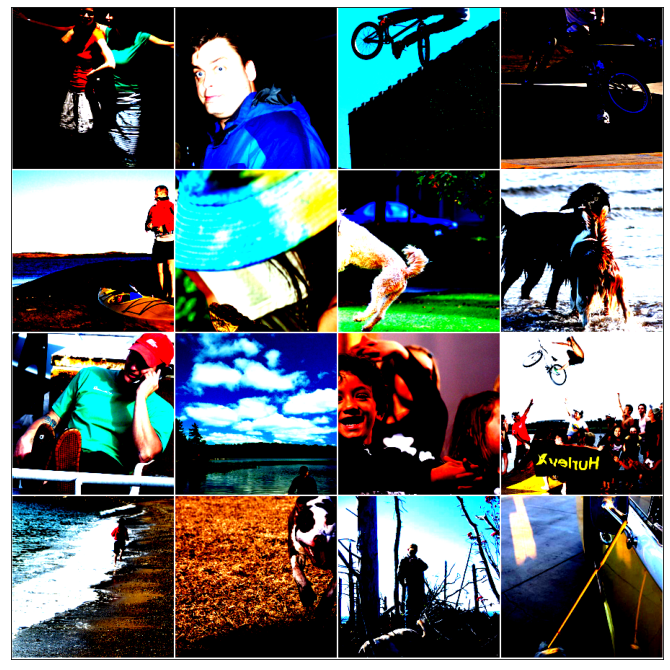

In [ ]:
show_batch(train_dl)

# Modelling 

As illustrated earlier, our model is going to consist of an Encoder architecture and a decoder Architecture.

The encoder RNN is going to be a pretrained model, ResNet152. The original paper 'Show, Attend and Tell' has been implemented using VGG16. 

**Note**: ResNet has been chosen based on the facts given the article linked [here.](https://cv-tricks.com/cnn/understand-resnet-alexnet-vgg-inception/)

There's also an interesting explanation available on this [here.](https://stats.stackexchange.com/questions/280179/why-is-resnet-faster-than-vgg/280338)

In [ ]:
torch.cuda.is_available()

True

We define a helper function to make sure that our model uses GPU if available, else CPU.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

The code below illustrates how we can load a batch of data from training set to our available device.

In [ ]:
for images, captions, lengths in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 3, 224, 224])
cuda:0


Now, the data is ready on the GPU. Next we'll define the model and then move it to the device.

We set the raining parameters beforehand.

In [ ]:
# Size of the embedding layer
embed_size = 256

# number of features in hidden state of the RNN decoder 
hidden_size = 512

# Number of layers in the LSTM
num_layers = 1

# Learning rate
learning_rate = 0.001

# Number of epochs
num_epochs = 5

# Log step defining when to print the epoch summary
log_step = 10

# Size of vocab file
vocab_size = len(map)

# Path to save checkpoints
model_path= root + "models/"

In [ ]:
import torchvision.models as models
model = models.resnet152()

In [ ]:
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

A short into about ResNet architecture. Unlike the other pre-trained models, ResNet has a residual blockto alleviate the effects of vanishing gradient during backpropagation. This unit’s structure is a feedforward network with a shortcut connection which adds new inputs into the network and generates new outputs. The main merit of this unit is that it produces better classification accuracy without increasing the complexity of the model. For more intuition on why ResNet works well, please check this [link.](https://cv-tricks.com/keras/understand-implement-resnets/)

So here, we consider the pre-trained model without the last fully connected layer.

In [ ]:
# Encoder class
class EncoderCNN(nn.Module):
  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()

    # Use pre-trained ResNet152 model
    resnet = models.resnet152(pretrained=True)

    # Remember to set the gradients to False. We do not want to apply back-propagation to the pre-trained model
    for param in resnet.parameters():
            param.requires_grad_(False)
    
    # Omitting the last layer of the model
    layers = list(resnet.children())[:-1]

    # Unpack the layers
    self.resnet = nn.Sequential(*layers)

    """ The last layer of the encoder should be of the size that is compatible with our decoder's first layer.

        The decoder architechture starts with the attention layer followed by the embedding layer and LSTM.
        
        So we set resize the output of the last fully connected layer to match the embed_size
    """

    # Set the embed_size as FC's output size
    self.linear = nn.Linear(resnet.fc.in_features, embed_size) 

    #Batch normalization to speed up training
    self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

  def forward(self, images):
    """ Forward propagation to extract 2048-dimensional vector in the latent space """
    features = self.resnet(images)
    
    # Reshape the feature vector
    features = features.view(features.size(0), -1)

    # Pass the features to the linear layer
    features = self.linear(features)

    # Apply batch normalization
    out_vector = self.bn(features)

    return out_vector   

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
       
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)

        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 

        hiddens, _ = self.lstm(packed) 
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        predicted_sentence  = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hidden, states = self.lstm(inputs, states)          # hidden : (batch_size, 1, hidden_size)
            outputs = self.linear(hidden.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            predicted_sentence.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        predicted_sentence = torch.stack(predicted_sentence, 1)    # predicted_sentence: (batch_size, max_seq_length)
        return predicted_sentence 

In [ ]:
# Initialize the encoder and decoder and move to device
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

In [ ]:
# Specify what parameters to be optimized
""" Parameters of the decoder, last layer if the pretrained model and the Batch normalization layer 
    of the encoder """
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())

import torch.nn.functional as F
# optimizer
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [ ]:
loss_lstm = []

encoder.train()
decoder.train()

if not os.path.exists(model_path):
    os.makedirs(model_path)

# before training
torch.save(encoder.state_dict(), os.path.join(model_path, 'CNN-encoder-0.ckpt'))
torch.save(decoder.state_dict(), os.path.join(model_path, 'LSTM-decoder-0.ckpt'))


In [ ]:
# Train the models
total_step = len(train_dl)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_dl):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = F.cross_entropy(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item())) 
    loss_lstm.append(loss.item())
    torch.save(decoder.state_dict(), os.path.join(model_path, 'LSTM-decoder-{}.ckpt'.format(epoch+1)))
    torch.save(encoder.state_dict(), os.path.join(model_path, 'CNN-encoder-{}.ckpt'.format(epoch+1)))
print('Finished')

Epoch [0/5], Step [0/301], Loss: 4.7544
Epoch [0/5], Step [10/301], Loss: 4.6326
Epoch [0/5], Step [20/301], Loss: 4.5011
Epoch [0/5], Step [30/301], Loss: 4.3984
Epoch [0/5], Step [40/301], Loss: 4.2619
Epoch [0/5], Step [50/301], Loss: 4.1617
Epoch [0/5], Step [60/301], Loss: 4.2183
Epoch [0/5], Step [70/301], Loss: 3.9461
Epoch [0/5], Step [80/301], Loss: 4.0204
Epoch [0/5], Step [90/301], Loss: 4.0503
Epoch [0/5], Step [100/301], Loss: 4.0458
Epoch [0/5], Step [110/301], Loss: 3.7924
Epoch [0/5], Step [120/301], Loss: 3.7516
Epoch [0/5], Step [130/301], Loss: 3.8792
Epoch [0/5], Step [140/301], Loss: 3.7427
Epoch [0/5], Step [150/301], Loss: 3.7365
Epoch [0/5], Step [160/301], Loss: 3.6409
Epoch [0/5], Step [170/301], Loss: 3.6812
Epoch [0/5], Step [180/301], Loss: 3.6773
Epoch [0/5], Step [190/301], Loss: 3.4486
Epoch [0/5], Step [200/301], Loss: 3.4989
Epoch [0/5], Step [210/301], Loss: 3.5464
Epoch [0/5], Step [220/301], Loss: 3.4661
Epoch [0/5], Step [230/301], Loss: 3.5686
Epo

In [ ]:
loss_lstm

[3.7529051303863525,
 2.8204736709594727,
 2.692894220352173,
 2.5192408561706543,
 2.556291103363037]

In [ ]:
def plot_loss(loss_lstm):
    x = np.arange(0, 5)

    plt.figure()
    plt.plot(x, loss_lstm, "b", ":", linewidth=1)

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss vs epoch for RNN")

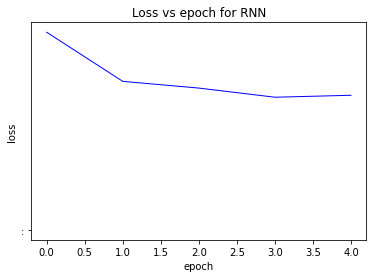

In [ ]:
plot_loss(loss_lstm)

Here we observe that the loss is lowest for epoch 3 and stabilizes later on. Let's evaluate the model on some sample images.


In [ ]:
# Sample 3 images at random from test set. Note than the samples in validation set starts from index 38444
valid_df.head()

torch.manual_seed(0)
# Randomly pick 3 rows from valid_df
sampled_imgs = valid_df.sample(3)['image'].to_list()
sampled_imgs

['818340833_7b963c0ee3.jpg',
 '862177617_c2c0581075.jpg',
 '890734502_a5ae67beac.jpg']

In [ ]:
def loadImage(image_path, transform=valid_txms):
    image = Image.open(image_path)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

image1 = loadImage(image_dir + sampled_imgs[0], valid_txms)
image2 = loadImage(image_dir + sampled_imgs[1], valid_txms)
image3 = loadImage(image_dir + sampled_imgs[2], valid_txms)


In [ ]:
img_id1 = sampled_imgs[0]
img_id2 = sampled_imgs[1]
img_id3 = sampled_imgs[2]


In [ ]:
# Function to transform index to words

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu


def transform_idx_to_words(input):
    sampled_caption = []

    for idx in input:
        word = map.idx2word[idx]
        sampled_caption.append(word)

        if word == '<end>':
            break
    
    output = ' '.join(sampled_caption[1:-1])
    output = output.replace(' ,', ',')
    
    return output.split(' ')

In [ ]:
epoch_checkpoint = ['0', '1', '2', '3', '4', '5']


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
show1_captions = []
show2_captions = []
show3_captions = []


for model_name in range(len(epoch_checkpoint)):
    print(model_name)
    encoder_model_path = os.path.join(model_path, 'CNN-encoder-{}.ckpt'.format(model_name))
    decoder_model_path = os.path.join(model_path, 'LSTM-decoder-{}.ckpt'.format(model_name))

    test_encoder = EncoderCNN(embed_size)
    test_decoder = DecoderRNN(embed_size, hidden_size, len(map), num_layers)    

    test_encoder.load_state_dict(torch.load(encoder_model_path))
    test_decoder.load_state_dict(torch.load(decoder_model_path))

    if torch.cuda.is_available():
        test_encoder = test_encoder.to(device)
        test_decoder = test_decoder.to(device)

    test_encoder.eval()
    test_decoder.eval()

    image1 = image1.to(device)
    image2 = image2.to(device)
    image3 = image3.to(device)


    predicted, actual = list(), list()
    predicted_total, actual_total = list(), list()    


    feature1 = test_encoder(image1)
    cap1 = test_decoder.sample(feature1)
    cap1 = cap1.cpu().data.numpy()


    feature2 = test_encoder(image2)
    cap2 = test_decoder.sample(feature2)
    cap2 = cap2.cpu().data.numpy()

    feature3 = test_encoder(image3)
    cap3 = test_decoder.sample(feature3)
    cap3 = cap3.cpu().data.numpy()


    predicted.append(cap1)
    predicted.append(cap2)
    predicted.append(cap3)

    predicted1 = " ".join(transform_idx_to_words(predicted[0][0,:]))
    predicted2 = " ".join(transform_idx_to_words(predicted[1][0,:]))
    predicted3 = " ".join(transform_idx_to_words(predicted[2][0,:]))

    # 1st image
    print("The generated caption of 1st image: " + predicted1)
    show1_captions.append(predicted1)

    # 2nd image
    print("The generated caption of 2nd image: " + predicted2)
    show2_captions.append(predicted2)
 
    # 3rd image
    print("The generated caption of 3rd image: " + predicted3)
    show3_captions.append(predicted3)

    print('done for model: {}'.format(model_name))

0
The generated caption of 1st image: photograph new glacier world branches leaping condoms calf arab library band driver badminton campfire diaper catches compete washing
The generated caption of 2nd image: times several several aiming read grab mouths liberty wading surfs cellphone produce computer cave vests headdress upon ravine
The generated caption of 3rd image: miniature sport amusement motorbike eggs cloudy seating lying eggs japanese tan owners basket frozen sides chew receives coming
done for model: 0
1
The generated caption of 1st image: the black and white dog is running through the snow
The generated caption of 2nd image: man in red shirt and white shirt and sunglasses is standing on the street
The generated caption of 3rd image: boy in red shirt is jumping into the water
done for model: 1
2
The generated caption of 1st image: white dog is running through the snow
The generated caption of 2nd image: woman in blue shirt is holding up sign
The generated caption of 3rd image:

In [ ]:
show1_captions

['photograph new glacier world branches leaping condoms calf arab library band driver badminton campfire diaper catches compete washing',
 'the black and white dog is running through the snow',
 'white dog is running through the snow',
 'black and white dog is running through the grass',
 'black and white bird is running through the woods',
 'black and white dog is running through the grass']

In [ ]:
actual_img1 = descriptions[img_id1]

Clearly, the model before training perfomed very badly. Hence we remove the prediction from checkpoint-0. 


In [ ]:
captions_img1 = show1_captions[1:]

In [ ]:
bleu1 = []
for i in range(len(captions_img1)):
  score = sentence_bleu(captions_img1[i], actual_img1[i] , weights=(0.5, 0.5, 0, 0))
  j = i+1
  bleu1.append((j,round(score,2)))
  print(f"BLEU score for model {j}: {score*100}")

BLEU score for model 1: 58.30951894845301
BLEU score for model 2: 50.48781642974013
BLEU score for model 3: 48.86777774252209
BLEU score for model 4: 55.32833351724881
BLEU score for model 5: 50.0


Calculating BLEU scores for the other images as well.

In [ ]:
actual_img2 = descriptions[img_id2]
captions_img2 = show2_captions[1:]

bleu2 = []
for i in range(len(captions_img2)):
  score = sentence_bleu(captions_img2[i], actual_img2[i] , weights=(0.5, 0.5, 0, 0))
  j = i+1
  bleu2.append((j,round(score,2)))
  print(f"BLEU score for model {j}: {score*100}")

BLEU score for model 1: 52.70462766947299
BLEU score for model 2: 58.38742081211422
BLEU score for model 3: 45.29108136578383
BLEU score for model 4: 53.03300858899106
BLEU score for model 5: 51.507875363771284


In [ ]:
actual_img3 = descriptions[img_id3]
captions_img3 = show3_captions[1:]

bleu3 = []
for i in range(len(captions_img3)):
  score = sentence_bleu(captions_img3[i], actual_img3[i] , weights=(0.5, 0.5, 0, 0))
  j = i+1
  bleu3.append((j,round(score,2)))
  print(f"BLEU score for model {j}: {score*100}")

BLEU score for model 1: 60.141676702564126
BLEU score for model 2: 60.30226891555272
BLEU score for model 3: 56.49326828660322
BLEU score for model 4: 57.735026918962575
BLEU score for model 5: 58.976782461958855


In [ ]:
bleu1

[(1, 0.58), (2, 0.5), (3, 0.49), (4, 0.55), (5, 0.5)]

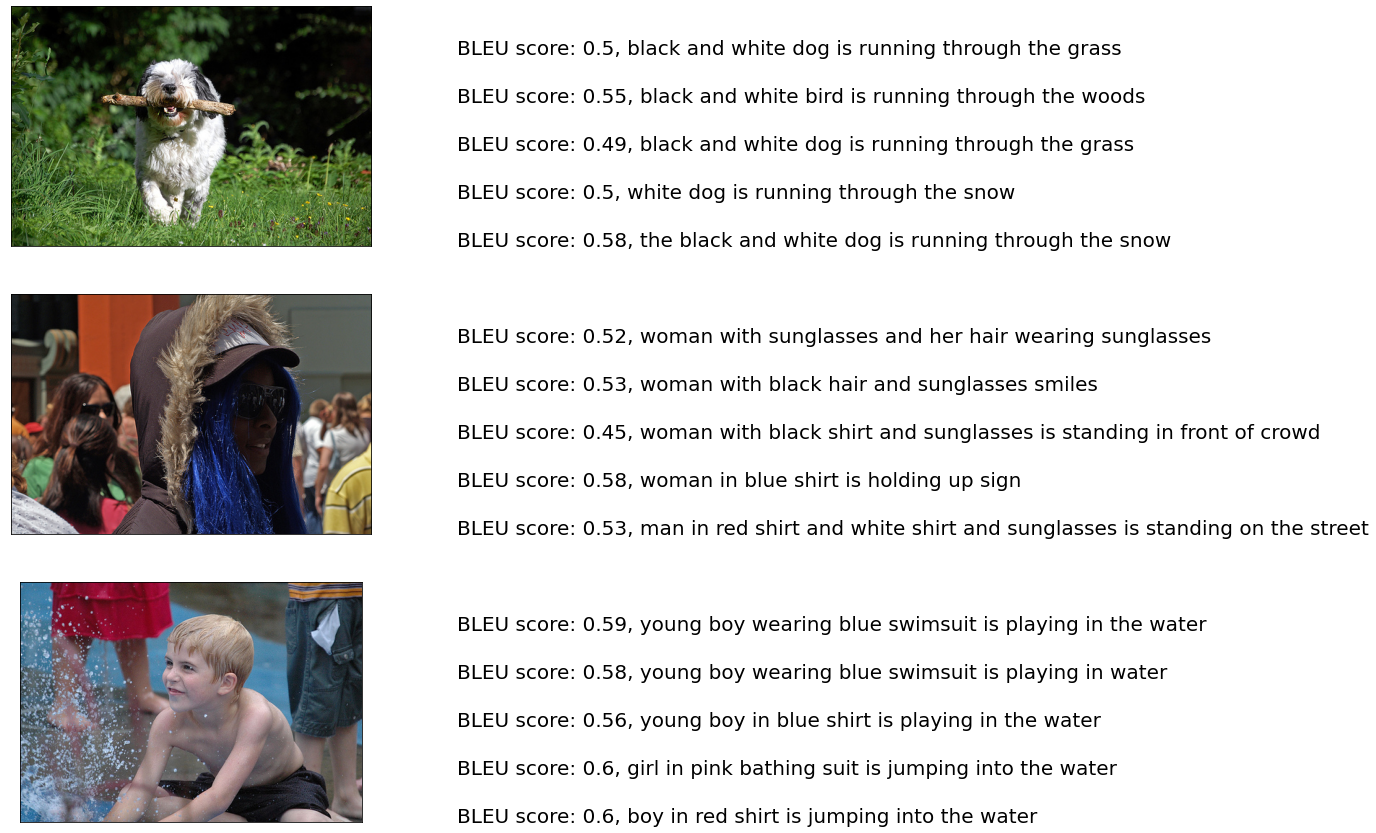

In [ ]:
# Visualize randomly sampled images alongside their captions
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

count = 1
fig = plt.figure(figsize = (15,15))

# Read the image from file
for a in range(len(sampled_imgs)):
  img_path = image_dir + sampled_imgs[a]
  
  
  # Open the image from 'images' folder
  pil_image = Image.open(img_path)
  
  # Convert PIL image to torch tensor
  rgb_img = pil2tensor(pil_image)
  
  # Fetch the captions for the sample images 
  if a == 0:
    targets = captions_img1
  elif a == 1:
    targets = captions_img2
  else:
    targets = captions_img3
 

  # Create a subplot grid 
  ax = fig.add_subplot(len(sampled_imgs), 2, count, xticks=[], yticks=[] )
  ax.imshow(rgb_img.numpy().transpose(1, 2, 0))

  # increment sub-plot index
  count += 1
   
  ax = fig.add_subplot(len(sampled_imgs),2,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(targets))
  # Place captions by the side of the image
  for i, caption in enumerate(targets):
      if a == 0:
          ax.text(0,i,'BLEU score: ' + str(bleu1[i][1]) + ', ' + caption,fontsize=20)
      elif a == 1:
          ax.text(0,i,'BLEU score: ' + str(bleu2[i][1]) + ', ' + caption,fontsize=20)
      else:
          ax.text(0,i,'BLEU score: ' + str(bleu3[i][1]) + ', ' + caption,fontsize=20)

  # increment sub-plot index
  count += 1

Let's see along with the actual captions to get a better picture.

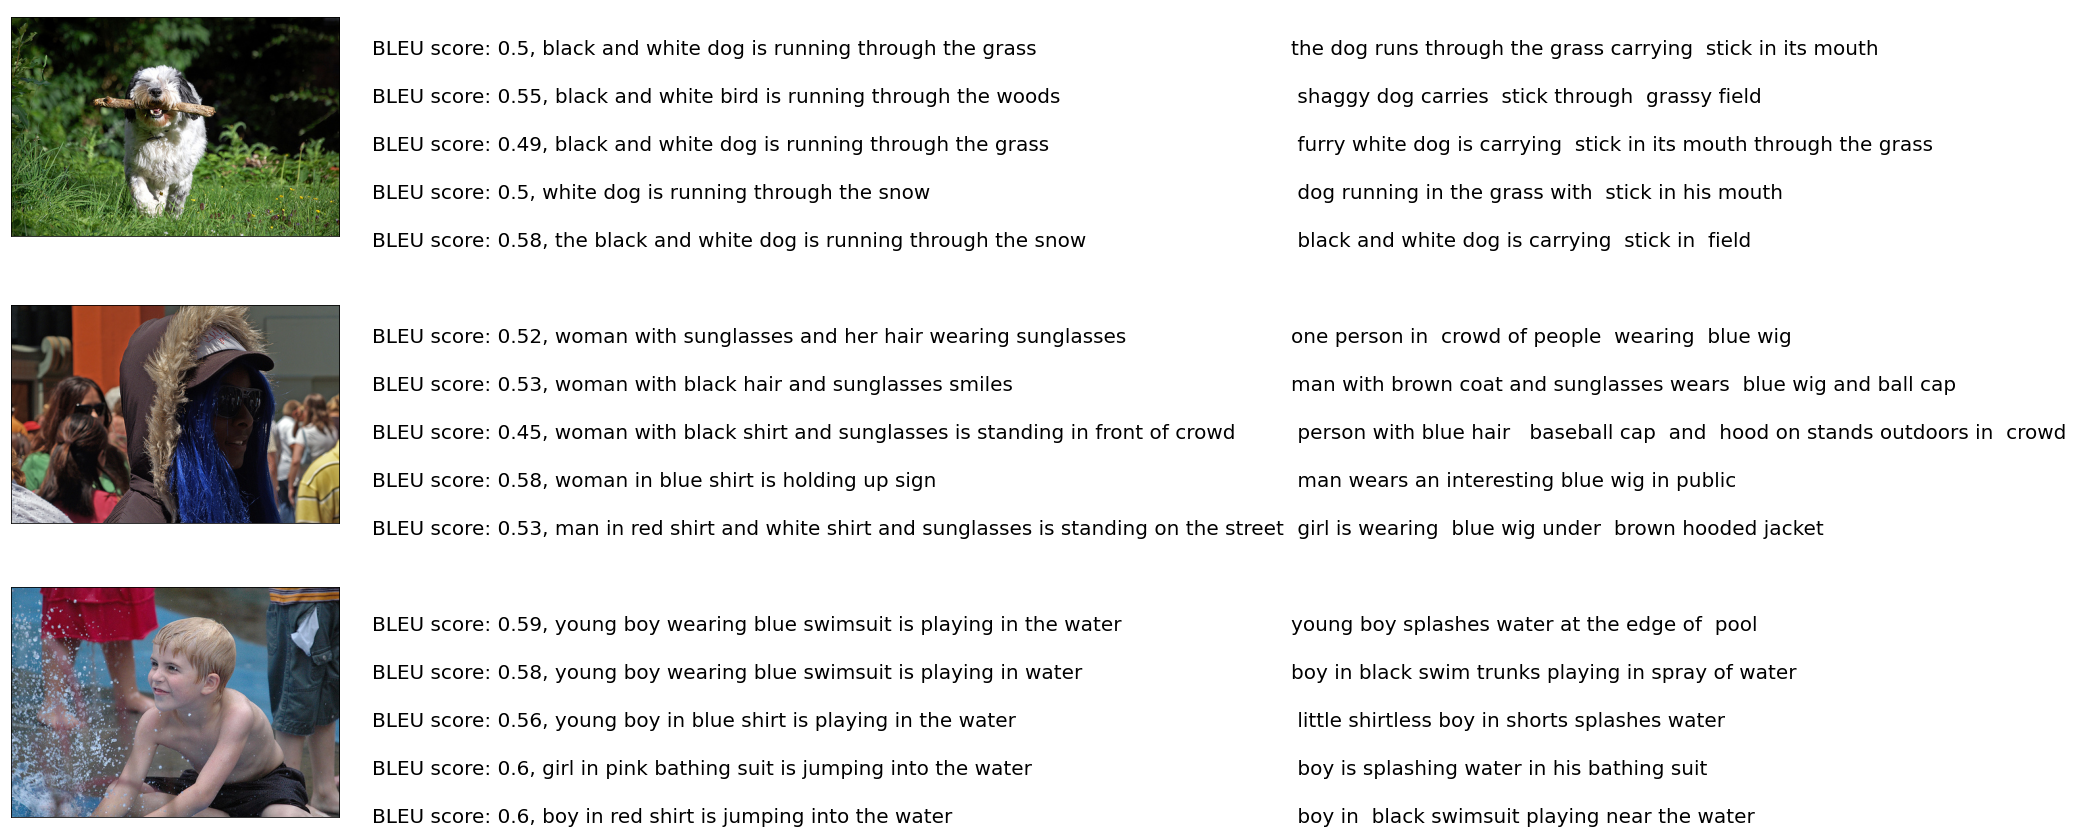

In [ ]:
# Visualize randomly sampled images alongside their captions
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

count = 1
fig = plt.figure(figsize = (20,15))

# Read the image from file
for a in range(len(sampled_imgs)):
  img_path = image_dir + sampled_imgs[a]
  
  
  # Open the image from 'images' folder
  pil_image = Image.open(img_path)
  
  # Convert PIL image to torch tensor
  rgb_img = pil2tensor(pil_image)
  
  # Fetch the captions for the sample images 
  if a == 0:
    targets = captions_img1
  elif a == 1:
    targets = captions_img2
  else:
    targets = captions_img3
 

  # Create a subplot grid 
  ax = fig.add_subplot(len(sampled_imgs), 3, count, xticks=[], yticks=[] )
  ax.imshow(rgb_img.numpy().transpose(1, 2, 0))

  # increment sub-plot index
  count += 1
   
  ax = fig.add_subplot(len(sampled_imgs),3,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(targets))
  # Place captions by the side of the image
  for i, caption in enumerate(targets):
      if a == 0:
          ax.text(-0.1,i,'BLEU score: ' + str(bleu1[i][1]) + ', ' + caption,fontsize=20, wrap=True)
      elif a == 1:
          ax.text(-0.1,i,'BLEU score: ' + str(bleu2[i][1]) + ', ' + caption,fontsize=20, wrap=True)
      else:
          ax.text(-0.1,i,'BLEU score: ' + str(bleu3[i][1]) + ', ' + caption,fontsize=20, wrap=True)
 

  # increment sub-plot index
  count += 1
  ax = fig.add_subplot(len(sampled_imgs),3,count)
  actual_captions = list(descriptions[sampled_imgs[a]])

  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(actual_captions))
  # Place captions by the side of the image
  for i, caption in enumerate(actual_captions):
      # Place captions by the side of the image
      ax.text(1.5,i,caption,fontsize=20, wrap=True)

  # increment sub-plot index
  count += 1




# Conclusion

We see that the model parameters at the third checkpoint (corresponding to CNN-encoder-3.ckpt and LSTM-decoder-3.ckpt) are performing reasonably well. 

**Future work**

We have gone through a baseline implementation of an image captioning project. Advanced techniques like visual attention and language transformers like BERT can be tried in sequence generation tasks. 